## AI-Powered Multi-Attribute Fashion Search and Prediction System
### A two-phase approach to fashion image understanding using attribute-based filtering and deep learning.

### Phase 2 – Prediction Model
#### A machine learning pipeline trained on the annotated dataset to automatically detect and predict fashion attributes from new, unseen images.

### 1. Setup & Configuration

This cell initializes everything needed for the multi-attribute prediction pipeline. It imports core Python utilities (I/O, JSON, timing), data tools (numpy, pandas), image/plotting helpers (PIL, matplotlib), and the full PyTorch stack (core, torchvision, data loaders, and transforms) used to build and train the model. A small seed_everything() utility fixes random seeds across Python, NumPy, and PyTorch (CPU/GPU) to make runs reproducible.

Next, it defines all project paths (root, images, captions, and three label files: shape, fabric, color/pattern). The final loop prints whether each path exists, acting as a quick sanity check before any heavy loading or training begins. If any path is reported “MISSING,” fix the directory or filenames here before proceeding.

In [5]:
#  !pip install torchvision
#  pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# from fashion_ds import FashionAttrDS, make_transforms, make_dataloaders
# from fashion_model import MultiTaskNet, make_nums, masked_ce, evaluate
import os, json, math, random, time
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(42)

# ---- Paths (EDIT if needed) ----
BASE = '/Users/krishna/Desktop/FinalProject'
IM_DIR   = os.path.join(BASE, 'images')
CAP_FILE = os.path.join(BASE, 'captions.json')

SHAPE_FILE  = os.path.join(BASE, 'labels/shape/shape_anno_all.txt')
FABRIC_FILE = os.path.join(BASE, 'labels/texture/fabric_ann.txt')
COLOR_FILE  = os.path.join(BASE, 'labels/texture/pattern_ann.txt')  # given spec calls it 'color' but file is named 'pattern_ann.txt'

# Ensure paths exist
for p in [BASE, IM_DIR, CAP_FILE, SHAPE_FILE, FABRIC_FILE, COLOR_FILE]:
    print(p, 'Path Exists' if os.path.exists(p) else 'MISSING')

/Users/krishna/Desktop/FinalProject Path Exists
/Users/krishna/Desktop/FinalProject/images Path Exists
/Users/krishna/Desktop/FinalProject/captions.json Path Exists
/Users/krishna/Desktop/FinalProject/labels/shape/shape_anno_all.txt Path Exists
/Users/krishna/Desktop/FinalProject/labels/texture/fabric_ann.txt Path Exists
/Users/krishna/Desktop/FinalProject/labels/texture/pattern_ann.txt Path Exists


### 2. Data Inventory & Inspection

In [7]:
from pathlib import Path

def count_images(root, exts={'.jpg', '.jpeg', '.png', '.bmp'}):
    n=0; listing=[]
    for p in Path(root).rglob('*'):
        if p.suffix.lower() in exts:
            n += 1; listing.append(str(p))
    return n, listing

n_images, image_list = count_images(IM_DIR)
print('Total image files found:', n_images)

Total image files found: 44096


In [8]:
# Peek a few file names
for p in image_list[:5]:
    print(' -', os.path.relpath(p, IM_DIR))

 - WOMEN-Tees_Tanks-id_00005085-31_4_full.jpg
 - WOMEN-Blouses_Shirts-id_00002061-02_4_full.jpg
 - WOMEN-Tees_Tanks-id_00006421-17_1_front.jpg
 - WOMEN-Sweaters-id_00004770-06_4_full.jpg
 - WOMEN-Sweaters-id_00005110-04_3_back.jpg


##### The below cell performs a light audit of captions to understand coverage and quality before training or using them downstream:
•	File presence & lookup set: Builds a set of image basenames from IM_DIR to quickly check whether each captioned image actually exists on disk.
•	Coverage report: If captions.json is found, it prints the total number of caption entries and shows the first five (image → caption) pairs for a quick visual check.
•	Existence overlap: Computes how many captioned images physically exist in IM_DIR (intersection size), helping catch path/name mismatches early.
•	Empty/placeholder detection: Counts captions that are empty or placeholders ('n', 'na', 'null'), which are not useful for text supervision or search.
•	Vocabulary snapshot: Produces a simple top-20 word frequency list to get a feel for common terms and potential biases (e.g., many “dress”, “black”, “long”), which can guide augmentation or cleaning.

In [10]:
import os
import json
from collections import Counter

# Paths
BASE = '/Users/krishna/Desktop/FinalProject'
IM_DIR = os.path.join(BASE, 'images')
CAP_FILE = os.path.join(BASE, 'captions.json')

# Build set of basenames from images directory
image_basenames = set(os.listdir(IM_DIR))

if os.path.exists(CAP_FILE):
    with open(CAP_FILE, 'r') as f:
        captions = json.load(f)

    print("Total captions entries:", len(captions))

    # Show a few samples
    for i, (img, cap) in enumerate(list(captions.items())[:5]):
        print(f"{i+1}. {img} -> {cap}")

    # How many caption entries have matching image files
    caption_img_names = set(captions.keys())
    intersection = caption_img_names & image_basenames
    print(f"\nImages in captions that exist in IM_DIR: {len(intersection)} / {len(caption_img_names)}")

    # Count empty or placeholder captions
    empty_count = sum(1 for v in captions.values() if not v or str(v).strip().lower() in {'n','na','null'})
    print(f"Empty or placeholder captions: {empty_count}")

    # Top words
    words = []
    for cap in captions.values():
        if isinstance(cap, str):
            words.extend(cap.lower().split())
    common_words = Counter(words).most_common(20)
    print("\nTop 20 most common words in captions:")
    for w, c in common_words:
        print(f"{w}: {c}")

else:
    print("No captions.json file found at", CAP_FILE)

Total captions entries: 42544
1. MEN-Denim-id_00000080-01_7_additional.jpg -> The lower clothing is of long length. The fabric is cotton and it has plaid patterns.
2. MEN-Denim-id_00000089-01_7_additional.jpg -> His tank top has sleeves cut off, cotton fabric and pure color patterns. The neckline of it is round. The pants this man wears is of long length. The pants are with cotton fabric and pure color patterns.
3. MEN-Denim-id_00000089-02_7_additional.jpg -> His sweater has long sleeves, cotton fabric and stripe patterns. The neckline of it is lapel. The gentleman wears a long pants. The pants are with cotton fabric and solid color patterns.
4. MEN-Denim-id_00000089-03_7_additional.jpg -> His shirt has short sleeves, cotton fabric and pure color patterns. It has a crew neckline. The person wears a long pants. The pants are with cotton fabric and solid color patterns.
5. MEN-Denim-id_00000089-04_7_additional.jpg -> The sweater the person wears has long sleeves, its fabric is denim, and

### Caption Length Analysis & Distribution Plots
This cell analyzes the length and quality of captions to understand how informative they are for downstream components (e.g., filtering context or weak supervision). It first loads captions.json, defines a small is_empty() guard to drop empty/placeholder entries ('', n, na, null), and then computes per-caption word counts and character counts. A small stats() helper summarizes each distribution (count, mean, median, 90th percentile, max) so you can quickly gauge typical caption sizes and the presence of very short/very long outliers.

Finally, it visualizes both word-count and character-count distributions as histograms. These plots help you decide, for example, whether to trim extremely long captions, augment very short ones, or set sensible tokenizer limits. In practice, a balanced spread with a reasonable median suggests captions are informative enough to support content-based search and to provide useful context alongside image-only models.

Caption length (words): {'count': 42537, 'mean': 40.44805698568305, 'median': 41.0, 'p90': 58.0, 'max': 93}
Caption length (chars): {'count': 42537, 'mean': 225.83924583303948, 'median': 230.0, 'p90': 322.0, 'max': 514}


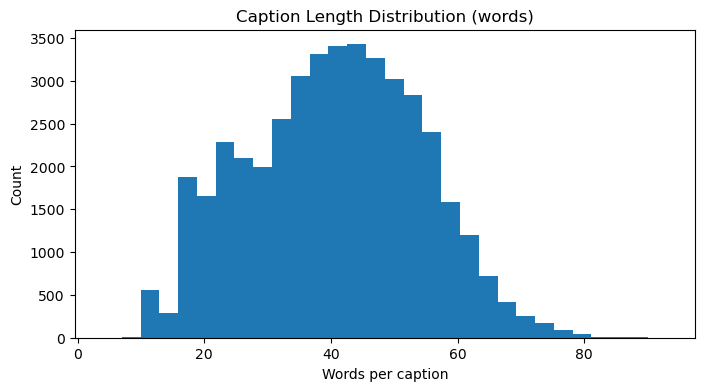

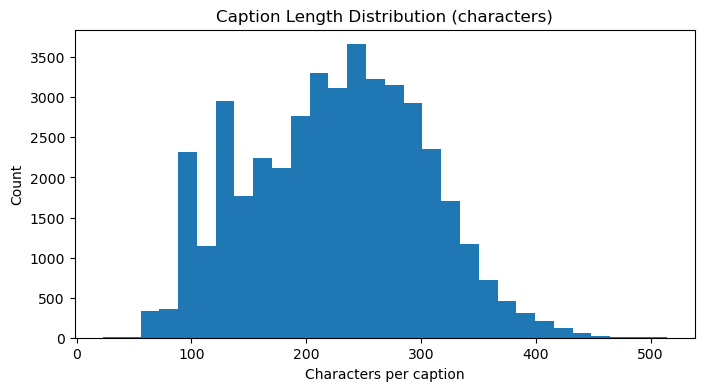

In [12]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

# Paths
BASE = '/Users/krishna/Desktop/FinalProject'
CAP_FILE = os.path.join(BASE, 'captions.json')

# Load captions
with open(CAP_FILE, 'r') as f:
    captions = json.load(f)

# Normalize & compute lengths (ignore empties / placeholders)
def is_empty(v):
    return (v is None) or (str(v).strip().lower() in {'', 'n', 'na', 'null'})
caps = [str(v).strip() for v in captions.values() if not is_empty(v)]
lengths_chars = [len(c) for c in caps]
lengths_words = [len(c.split()) for c in caps]

# Basic stats
def stats(arr):
    a = np.array(arr)
    return {
        'count': int(a.size),
        'mean': float(a.mean()) if a.size else 0,
        'median': float(np.median(a)) if a.size else 0,
        'p90': float(np.percentile(a, 90)) if a.size else 0,
        'max': int(a.max()) if a.size else 0
    }

print("Caption length (words):", stats(lengths_words))
print("Caption length (chars):", stats(lengths_chars))

# Plot histograms
plt.figure(figsize=(8,4))
plt.hist(lengths_words, bins=30)
plt.title('Caption Length Distribution (words)')
plt.xlabel('Words per caption'); plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(lengths_chars, bins=30)
plt.title('Caption Length Distribution (characters)')
plt.xlabel('Characters per caption'); plt.ylabel('Count')
plt.show()

### Loading Raw Label Files (Shape, Fabric, Color)
##### This cell is focused on loading the raw annotation files for fashion attributes before merging them into a single dataset. A small helper function load_txt(path) is defined, which reads a tab-separated text file into a pandas DataFrame. This function is applied to the three primary annotation files:

SHAPE_FILE → Contains 12 columns of shape-related binary/multiclass labels for garments (e.g., sleeve length, pant length, hat presence).

FABRIC_FILE → Provides upper, lower, and outer fabric type labels.

COLOR_FILE → Provides upper, lower, and outer color/pattern annotations.

After loading, the script prints out the row counts (shape) of each DataFrame as well as the first row examples. This serves as a sanity check to verify that the label files were read correctly, contain the expected number of rows/columns, and are properly structured.

By confirming the shape and example rows early, you avoid silent misreads of the text files (e.g., wrong delimiter, missing headers). This ensures that the downstream merging step will operate on valid, structured annotations, forming the basis for multi-attribute training and prediction in later phases.

In [14]:
# Count lines / unique images in label files
def load_txt(path):
    df = pd.read_csv(path, sep=r'\s+', header=None)
    return df

shape_raw  = load_txt(SHAPE_FILE)
fabric_raw = load_txt(FABRIC_FILE)
color_raw  = load_txt(COLOR_FILE)

print('Shape rows:',  shape_raw.shape, 'example row:', shape_raw.iloc[0].tolist()[:6], '...')
print('Fabric rows:', fabric_raw.shape, 'example row:', fabric_raw.iloc[0].tolist())
print('Color rows:',  color_raw.shape, 'example row:', color_raw.iloc[0].tolist())

Shape rows: (42544, 13) example row: ['MEN-Denim-id_00000080-01_7_additional.jpg', 5, 3, 0, 0, 0] ...
Fabric rows: (44096, 4) example row: ['MEN-Denim-id_00000080-01_7_additional.jpg', 1, 1, 7]
Color rows: (44096, 4) example row: ['MEN-Denim-id_00000080-01_7_additional.jpg', 3, 4, 7]


### Validating and Renaming Label File Columns
This cell performs two important steps to ensure the integrity and usability of the annotation files before merging them into the master dataset:

##### 1. Column Count Validation
Each annotation file is expected to follow a strict format:

Shape file → 1 column for the image name + 12 columns for shape-related attributes = 13 total.

Fabric file → 1 column for the image name + 3 fabric attributes (upper, lower, outer) = 4 total.

Color file → 1 column for the image name + 3 color/pattern attributes (upper, lower, outer) = 4 total.

The assert statements check these expectations, and if any file deviates (e.g., missing columns or extra values), the code raises an error immediately. This prevents silent errors that would corrupt the merged dataset.

##### 2. Renaming Columns with Descriptive Labels
Once validated, the columns are renamed for clarity and consistency:

Shape annotations are renamed as shape_0 through shape_11, making it clear each corresponds to a specific attribute (e.g., sleeve length, hat presence).

Fabric annotations are mapped to upper_fabric, lower_fabric, and outer_fabric.

Color annotations are mapped to upper_color, lower_color, and outer_color.

These descriptive names allow the dataset to be programmatically accessed in later steps (for filtering, training, and evaluation) without ambiguity.

In [16]:
# Ensure expected column counts (1 image name + values)
assert shape_raw.shape[1] == 1+12,  f"Expected 13 columns in shape, got {shape_raw.shape[1]}"
assert fabric_raw.shape[1] == 1+3,  f"Expected 4 columns in fabric, got {fabric_raw.shape[1]}"
assert color_raw.shape[1]  == 1+3,  f"Expected 4 columns in color, got {color_raw.shape[1]}"

# Rename columns
shape_raw.columns  = ['image'] + [f'shape_{i}' for i in range(12)]
fabric_raw.columns = ['image','upper_fabric','lower_fabric','outer_fabric']
color_raw.columns  = ['image','upper_color','lower_color','outer_color']

### Caption Table, ID Uniqueness & Coverage Audit
This cell builds a caption DataFrame (if captions.json exists) and then audits basic dataset integrity across all sources before training:

Caption Table Construction:
Loads captions.json when available and converts it to a two-column DataFrame (image, caption). Falls back to an empty DataFrame if captions are absent, so downstream code remains safe.

Uniqueness Checks:
Reports the count of unique image IDs found separately in the shape, fabric, color, and caption files. This quickly reveals duplication or ID drift across label sources.

Filesystem Alignment:
Builds a set of actual image basenames present under IM_DIR and prints a small sample. Ensures that what the labels reference truly exists on disk.

Coverage Statistics (per source):
For each label table, prints:
rows → number of unique image IDs in that source.
match-images → how many of those IDs exist in the image folder.
missing-images → how many IDs are referenced by labels but not found in IM_DIR.

The same coverage check is run for captions (if present).These checks help us catch broken links, missing images, or inconsistent IDs before you merge tables or start training—saving time and avoiding subtle bugs later.

In [18]:
captions = {}
if os.path.exists(CAP_FILE):
    with open(CAP_FILE) as f:
        captions = json.load(f)
cap_df = pd.DataFrame(list(captions.items()), columns=['image','caption']) if captions else pd.DataFrame(columns=['image','caption'])
# Uniqueness & intersections
def uniq_count(col):
    return col.nunique(dropna=True)

print('\nUnique image IDs per file:')
print(' shape:',  uniq_count(shape_raw['image']))
print(' fabric:', uniq_count(fabric_raw['image']))
print(' color:',  uniq_count(color_raw['image']))
if len(cap_df):
    print(' captions:', uniq_count(cap_df['image']))

# Build a set of available image filenames in IM_DIR
image_basenames = set(os.path.basename(p) for p in image_list)
print('\nSample of image basenames:', list(sorted(list(image_basenames))[:5]))

# Coverage stats
def coverage(label_df, label_name):
    have = set(label_df['image'].astype(str))
    inter = have & image_basenames
    print(f'{label_name}: rows={len(have)} | match-images={len(inter)} | missing-images={len(have - image_basenames)}')
coverage(shape_raw, 'shape')
coverage(fabric_raw, 'fabric')
coverage(color_raw,  'color')
if len(cap_df):
    coverage(cap_df, 'captions')


Unique image IDs per file:
 shape: 42544
 fabric: 44096
 color: 44096
 captions: 42544

Sample of image basenames: ['MEN-Denim-id_00000080-01_7_additional.jpg', 'MEN-Denim-id_00000089-01_7_additional.jpg', 'MEN-Denim-id_00000089-02_7_additional.jpg', 'MEN-Denim-id_00000089-03_7_additional.jpg', 'MEN-Denim-id_00000089-04_7_additional.jpg']
shape: rows=42544 | match-images=42544 | missing-images=0
fabric: rows=44096 | match-images=44096 | missing-images=0
color: rows=44096 | match-images=44096 | missing-images=0
captions: rows=42544 | match-images=42544 | missing-images=0


### 3. Merge Metadata (Labels + Captions)

This cell merges all annotation sources into a single table and guarantees that every row corresponds to a physically present image:

Outer merge of labels:
shape_raw, fabric_raw, and color_raw are merged on image with how='outer' to preserve every labeled entry, even if some attributes are missing. Captions are then attached with a left join so they’re included when available without discarding rows that lack captions.

Filesystem alignment:
After merging, the DataFrame is filtered to images that actually exist in IM_DIR (using the image_basenames set). This prevents downstream loaders from failing on missing files and ensures training/evaluation only uses valid items.

Result:
The printout shows the final row count, and head(3) provides a quick visual check of the unified metadata table (image → shape, fabric, color, caption). This table is the single source of truth for the rest of Phase 2.

In [21]:
labels_df = shape_raw.merge(fabric_raw, on='image', how='outer')\
                     .merge(color_raw,  on='image', how='outer')\
                     .merge(cap_df,     on='image', how='left')

# Keep only rows whose image actually exists in IM_DIR
labels_df = labels_df[labels_df['image'].astype(str).isin(image_basenames)].reset_index(drop=True)
print('Merged rows (with existing images):', len(labels_df))
labels_df.head(3)

Merged rows (with existing images): 44096


,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,shape_9,shape_10,shape_11,upper_fabric,lower_fabric,outer_fabric,upper_color,lower_color,outer_color,caption
0,MEN-Denim-id_00000080-01_7_additional.jpg,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,1,1,7,3,4,7,The lower clothing is of long length. The fabr...
1,MEN-Denim-id_00000089-01_7_additional.jpg,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,1.0,1,1,7,3,3,7,"His tank top has sleeves cut off, cotton fabri..."
2,MEN-Denim-id_00000089-02_7_additional.jpg,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,1.0,1.0,1,1,7,2,3,7,"His sweater has long sleeves, cotton fabric an..."


#### Label Completeness Check & Type Sanitization
This cell does two data-hygiene passes before splitting and training:
Shape-label coverage audit:
Builds the 12 shape columns list and computes two masks:
missing_any_shape → rows missing at least one shape attribute.
missing_all_shapes → rows missing all shape attributes.
Printing the counts helps you decide how strict to be during training/eval (e.g., exclude rows with no shape labels from strict validation).

Datatype normalization:
Converts all attribute columns (12 shape + 3 fabric + 3 color) to nullable integers (Int64) using pd.to_numeric(..., errors='coerce').
This coerces non-numeric glitches to NaN and ensures consistent dtypes across heads, which is critical for clean loss masking and batching later.

In [23]:
# 1) Confirm the same rows are missing all shapes
shape_cols = [f'shape_{i}' for i in range(12)]
missing_any_shape = labels_df[shape_cols].isna().any(axis=1)
missing_all_shapes = labels_df[shape_cols].isna().all(axis=1)
print("Missing ANY shape cols:", missing_any_shape.sum())
print("Missing ALL shape cols:", missing_all_shapes.sum())

# 2) Ensure integer dtypes where present
for c in shape_cols + ['upper_fabric','lower_fabric','outer_fabric','upper_color','lower_color','outer_color']:
    labels_df[c] = pd.to_numeric(labels_df[c], errors='coerce').astype('Int64')

Missing ANY shape cols: 1552
Missing ALL shape cols: 1552


### 4. Load Keypoints (21 points) & Merge

#### Keypoints Integration and Normalization
This cell handles the optional human keypoints data, which can be useful for pose-aware attribute prediction:
Path setup and default:
It constructs paths for keypoints_loc.txt (x–y coordinates) and keypoints_vis.txt (visibility flags). An empty DataFrame with only an image column is prepared as a placeholder in case the files are missing.
Loading coordinates and visibility:
If both files exist:

keypoints_loc.txt is loaded, which must contain 43 columns (1 for image name + 42 values for 21 keypoints, each with x and y).

keypoints_vis.txt is loaded, expected to contain 22 columns (1 image + 21 visibility flags).
Column names are expanded into structured labels like kp_1_x, kp_1_y, and kp_1_vis.

Merging and cleaning:
Both DataFrames are merged on image, creating a unified keypoints table. Invalid coordinates marked as (-1, -1) are replaced with NaN to indicate missing/unusable points, ensuring the model won’t misinterpret them as real positions.

Output:
Finally, the number of valid rows is printed, and the first two rows are displayed as a preview.

This step enriches the metadata with pose information, which could later help refine attribute predictions (e.g., distinguishing sleeve lengths by arm positions). It also safeguards the dataset by normalizing invalid entries into a consistent missing-value representation.

In [26]:
KP_LOC = os.path.join(BASE, 'keypoints/keypoints_loc.txt')
KP_VIS = os.path.join(BASE, 'keypoints/keypoints_vis.txt')

kp_df = pd.DataFrame(columns=['image'])

if os.path.exists(KP_LOC) and os.path.exists(KP_VIS):
    # load coords: 1 name + 42 numbers
    loc_df = pd.read_csv(KP_LOC, sep=r'\s+', header=None)
    assert loc_df.shape[1] == 43, f"Expected 43 columns in keypoints_loc (1+42), got {loc_df.shape[1]}"
    loc_df.columns = ['image'] + sum([[f'kp_{i}_x', f'kp_{i}_y'] for i in range(1,22)], [])

    vis_df = pd.read_csv(KP_VIS, sep=r'\s+', header=None)
    assert vis_df.shape[1] == 22, f"Expected 22 columns in keypoints_vis (1+21), got {vis_df.shape[1]}"
    vis_df.columns = ['image'] + [f'kp_{i}_vis' for i in range(1,22)]

    kp_df = loc_df.merge(vis_df, on='image', how='inner')

    # normalize (-1,-1) to NaN
    for i in range(1,22):
        x, y = f'kp_{i}_x', f'kp_{i}_y'
        m = (kp_df[x]==-1) & (kp_df[y]==-1)
        kp_df.loc[m, [x,y]] = np.nan

print('Keypoints rows:', len(kp_df))
kp_df.head(2)

Keypoints rows: 12702


,image,kp_1_x,kp_1_y,kp_2_x,kp_2_y,kp_3_x,kp_3_y,kp_4_x,kp_4_y,kp_5_x,...,kp_12_vis,kp_13_vis,kp_14_vis,kp_15_vis,kp_16_vis,kp_17_vis,kp_18_vis,kp_19_vis,kp_20_vis,kp_21_vis
0,MEN-Tees_Tanks-id_00007466-05_7_additional.jpg,429.0,55.0,382.0,130.0,408.0,106.0,446.0,106.0,469.0,...,0,0,0,0,0,0,0,0,0,0
1,WOMEN-Tees_Tanks-id_00004475-03_7_additional.jpg,417.0,20.0,364.0,93.0,387.0,79.0,424.0,89.0,448.0,...,0,0,0,0,0,0,0,0,0,0


### 5. Final Table (labels + optional keypoints)

#### Merging Metadata with Keypoints and Handling NaN Values

In this step, we merge the attribute labels (shape, fabric, color, captions) with 
the optional keypoint annotations into a single DataFrame `meta`. 
Since not all images have keypoint data (or complete attribute annotations), 
the merge naturally introduces **NaN values** in some columns.

These NaNs are **not errors**—they indicate missing labels or unavailable keypoints.  
We keep them as-is because:

1. **For Training:**  
   NaN labels are later replaced with `-100` (ignore index) during loss computation, 
   so the model does not learn from incomplete annotations.  

2. **For Filtering/Search (Phase 1):**  
   Missing values are mapped to `"NA"` strings in dropdowns, ensuring the interactive 
   search tool can still run smoothly.  

3. **For Keypoints:**  
   Missing keypoint coordinates remain `NaN`, clearly marking that the image 
   lacks pose information instead of incorrectly filling values.  

This approach maintains dataset integrity while ensuring the system is robust 
to incomplete data, avoiding bias from forced imputations.


In [29]:
meta = labels_df.merge(kp_df, on='image', how='left')  # keypoints are optional
print('Final meta rows:', len(meta))
meta.sample(3, random_state=1)

Final meta rows: 44096


,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,...,kp_12_vis,kp_13_vis,kp_14_vis,kp_15_vis,kp_16_vis,kp_17_vis,kp_18_vis,kp_19_vis,kp_20_vis,kp_21_vis
40653,WOMEN-Tees_Tanks-id_00005618-02_2_side.jpg,3,4,3,0,0,0,0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32825,WOMEN-Tees_Tanks-id_00000048-02_7_additional.jpg,0,4,3,0,0,0,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43654,WOMEN-Tees_Tanks-id_00007731-03_4_full.jpg,0,0,0,0,0,1,0,1,3,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 6.Visualizing Images with Keypoints

This function allows us to **visualize both the raw fashion image and its 
associated keypoint annotations**. Keypoints represent human body landmarks 
(e.g., head, shoulders, knees, ankles) that can help in understanding pose, 
garment fitting, and alignment of clothing.  

- The function `plot_image_and_keypoints` loads the image by file name, 
  displays it with Matplotlib, and then overlays the corresponding keypoints 
  if available.  
- For each of the 21 keypoints, the x–y coordinates are extracted 
  (`kp_i_x`, `kp_i_y`) along with their visibility status (`kp_i_vis`).  
- Keypoints are drawn with **different styles based on visibility**:  
  - `vs==0` → visible points shown as solid dots.  
  - `vs==1` → points marked with open circles (detected but less confident).  
  - `vs==2` or missing → very small markers, or ignored if coordinates are NaN.  
- Each keypoint is also **labeled with its index number** for reference, 
  making it easier to debug or map back to the body part definition.  

This step is crucial for validating whether **pose information aligns correctly 
with the visual image**, ensuring that errors in keypoint annotation (e.g., 
misaligned coordinates or missing joints) are spotted early before training 
pose-aware models or integrating with attribute prediction.

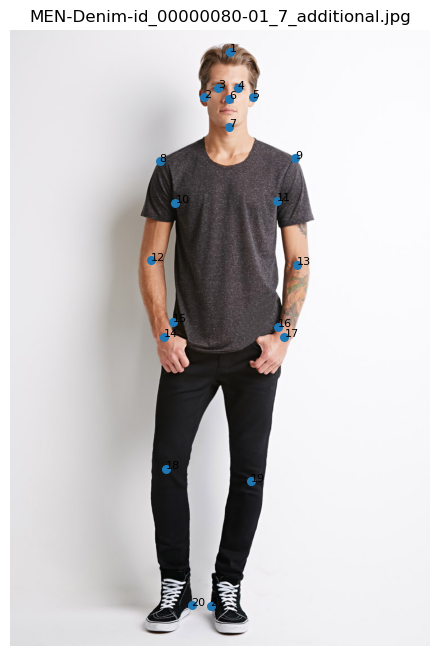

In [31]:
def plot_image_and_keypoints(img_name, row, figsize=(6,8)):
    path = os.path.join(IM_DIR, img_name)
    if not os.path.exists(path):
        print("Image not found:", path); return
    img = Image.open(path).convert('RGB')
    plt.figure(figsize=figsize); plt.imshow(img); plt.axis('off'); plt.title(img_name)

    # if keypoints present
    if any(col.startswith('kp_') for col in row.index):
        xs = np.array([row.get(f'kp_{i}_x') for i in range(1,22)], float)
        ys = np.array([row.get(f'kp_{i}_y') for i in range(1,22)], float)
        vs = np.array([row.get(f'kp_{i}_vis') for i in range(1,22)], float)
        if len(xs)>0:
            m0 = (vs==0)
            plt.scatter(xs[m0], ys[m0], s=30, marker='o')
            m1 = (vs==1)
            plt.scatter(xs[m1], ys[m1], s=30, facecolors='none', edgecolors='black', linewidths=1.5)
            m2 = (vs==2) | np.isnan(xs) | np.isnan(ys)
            plt.scatter(xs[m2], ys[m2], s=10)
            for i,(x,y) in enumerate(zip(xs,ys), start=1):
                if not (np.isnan(x) or np.isnan(y)):
                    plt.text(x, y, str(i), fontsize=8)

# try plotting one sample
row = meta.iloc[0]
plot_image_and_keypoints(row['image'], row)

##### This Below cell performs a last round of data cleaning and validation before training, and assembles the canonical meta table used by the loaders:
##### De-duplication:
Removes duplicate rows by image in both labels_df and kp_df to avoid double-counting samples during training or evaluation.
##### Merge with optional keypoints:
Left-joins labels_df and kp_df on image, preserving all labeled images and attaching keypoints where available. Prints the total row count and how many rows actually have any keypoint fields populated.
##### Filesystem sanity check:
Verifies that every image referenced in meta exists in IM_DIR. The printed count of missing files should be 0; otherwise, fix paths or filter those rows.
##### Robust dtypes for labels:
Converts all attribute columns (12 shape_*, plus upper/lower/outer fabric & color) to nullable integer (Int64). Invalid or missing entries become NaN, which will later be ignored in the loss instead of corrupting supervision.
##### Visibility code validation:
Confirms keypoint visibility flags are in the expected set {0, 1, 2} (or NaN). Any unexpected codes are reported for cleanup.
##### Quick preview:
Displays a random sample of rows to visually confirm the merged schema (image → attributes → optional keypoints) looks correct.
This compact hygiene pass ensures the training/evaluation code receives a clean, consistent, and verifiable dataset, minimizing surprises later in the pipeline.

In [33]:
# 0) (Optional) de-dup just in case
labels_df = labels_df.drop_duplicates(subset=['image']).reset_index(drop=True)
kp_df     = kp_df.drop_duplicates(subset=['image']).reset_index(drop=True)

# 1) Merge (keypoints are optional)
meta = labels_df.merge(kp_df, on='image', how='left')

print('Final meta rows:', len(meta))          # should match labels_df rows
print('Rows with keypoints:', meta[[c for c in meta.columns if c.startswith('kp_')]].notna().any(axis=1).sum())

# 2) Quick sanity: no missing image paths
missing_imgs = ~meta['image'].astype(str).isin(set(os.listdir(IM_DIR)))
print('Rows referencing files not in images dir:', int(missing_imgs.sum()))

# 3) Enforce integer dtypes where present (keeps NaN as <Int64>)
shape_cols = [f'shape_{i}' for i in range(12)]
attr_cols = shape_cols + ['upper_fabric','lower_fabric','outer_fabric',
                          'upper_color','lower_color','outer_color']
for c in attr_cols:
    meta[c] = pd.to_numeric(meta[c], errors='coerce').astype('Int64')

# 4) Optional: check visibility value range (0,1,2 or NaN)
vis_cols = [c for c in meta.columns if c.endswith('_vis')]
if vis_cols:
    bad = set(np.unique(pd.to_numeric(meta[vis_cols].stack(), errors='coerce').dropna())) - {0,1,2}
    print('Unexpected vis codes:', bad if bad else 'None')

# 5) Peek a few rows
meta.sample(3, random_state=1)

Final meta rows: 44096
Rows with keypoints: 12702
Rows referencing files not in images dir: 0
Unexpected vis codes: None


,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,...,kp_12_vis,kp_13_vis,kp_14_vis,kp_15_vis,kp_16_vis,kp_17_vis,kp_18_vis,kp_19_vis,kp_20_vis,kp_21_vis
40653,WOMEN-Tees_Tanks-id_00005618-02_2_side.jpg,3,4,3,0,0,0,0,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32825,WOMEN-Tees_Tanks-id_00000048-02_7_additional.jpg,0,4,3,0,0,0,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43654,WOMEN-Tees_Tanks-id_00007731-03_4_full.jpg,0,0,0,0,0,1,0,1,3,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 7. Encode Labels & Train/Val Split

This cell defines a robust splitting strategy that respects missing labels while preserving evaluation integrity:
##### Heads & required labels:
shape_cols (12 heads) plus fabric/color heads form required_cols. These are the labels we evaluate on.

##### Strict evaluation set (val_df):
Build strict_eval by dropping any rows with missing values across all required heads. From this fully labeled pool, sample 10% (fixed random_state=42) for validation. This guarantees that every metric you report uses complete ground truth.

##### Loose training set (train_df):
Start from all rows (train_base), then exclude any images used in val_df. This allows training to leverage partially labeled samples; missing labels will be ignored in the loss later (via masking), increasing data efficiency.

##### Sanity prints:
Show the final sizes of train_df and val_df, and how many samples in each split include keypoints (optional signal you might leverage later).

##### This split policy yields fair evaluation (strict) and maximal data usage for learning (loose), a practical approach for real-world datasets with incomplete annotations.

In [36]:
from sklearn.model_selection import train_test_split

shape_cols = [f'shape_{i}' for i in range(12)]
required_cols = shape_cols + [
    'upper_fabric','lower_fabric','outer_fabric',
    'upper_color','lower_color','outer_color'
]

# --- Build strict eval (all labels present) ---
strict_eval = meta.dropna(subset=required_cols).reset_index(drop=True)

# --- Loose training (use everything; missing labels will be ignored) ---
train_base = meta.reset_index(drop=True)

# Hold out 10% of strict set for validation
val_df = strict_eval.sample(frac=0.10, random_state=42).reset_index(drop=True)

# Train = everything that is NOT in val_df (loose)
train_df = train_base[~train_base['image'].isin(val_df['image'])].reset_index(drop=True)

print("Loose-train rows:", len(train_df))
print("Strict-eval rows:", len(val_df))
print("Keypoints in train:", int(train_df[[c for c in train_df.columns if c.startswith('kp_')]].notna().any(axis=1).sum()))
print("Keypoints in val:  ", int(val_df[[c for c in val_df.columns if c.startswith('kp_')]].notna().any(axis=1).sum()))

Loose-train rows: 39842
Strict-eval rows: 4254
Keypoints in train: 11458
Keypoints in val:   1244


### 8. Heads, Dataset and Dataloaders

This cell builds the PyTorch dataset pipeline for training and validating the multi-attribute prediction model.

##### 1. Attribute Heads
The list HEADS defines all prediction targets:
12 shape attributes (shape_0 … shape_11).
6 material/appearance attributes (upper_fabric, lower_fabric, outer_fabric, upper_color, lower_color, outer_color).
These serve as keys for label extraction and prediction heads in the neural network.

##### 2. Custom Dataset — FashionAttrDS
Wraps the DataFrame (train_df or val_df) into a PyTorch Dataset.
Image loading: Opens each file with PIL, converts to RGB, and applies a transform pipeline (augmentation or normalization).

##### Label handling:
Iterates over all HEADS.
Missing labels (NaN) are encoded as -100, which PyTorch’s cross-entropy loss ignores.
Valid labels are cast to torch.long tensors.
Return values: (image_tensor, labels_dict, filename) per sample, which makes debugging easier.

##### 3. Image Transformations
Training transform (train_tf):
Resize, random crop, horizontal flip → adds variability to avoid overfitting.
Normalize with ImageNet stats (mean/std), since ResNet-18 backbone expects that.
Validation transform (val_tf):
Resize + center crop → ensures consistency for evaluation.
Same normalization applied.

##### 4. DataLoaders
Wrap datasets in DataLoader for batch processing:
train_dl: batch size 32, shuffled every epoch.
val_dl: batch size 64, no shuffle (evaluation order doesn’t matter).
num_workers=0 avoids multiprocessing issues in Jupyter; pin_memory disabled for portability.

##### 5. Output
The last line prints dataset sizes for training and validation, confirming that splitting worked as intended.

This cell essentially prepares the input pipeline that feeds preprocessed images and their corresponding (multi-attribute) labels into the ResNet model for training and evaluation.

In [39]:
# ---- Heads you’ll train ----
import torch, pandas as pd, numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

shape_cols = [f'shape_{i}' for i in range(12)]
HEADS = shape_cols + [
    'upper_fabric','lower_fabric','outer_fabric',
    'upper_color','lower_color','outer_color'
]

# ---- Robust Dataset (ignores missing labels with -100) ----
class FashionAttrDS(Dataset):
    def __init__(self, frame: pd.DataFrame, img_dir: str, transform, heads):
        self.frame = frame.reset_index(drop=True)
        self.dir = img_dir
        self.t = transform
        self.heads = heads
    def __len__(self): return len(self.frame)
    def __getitem__(self, i):
        r = self.frame.iloc[i]
        x = Image.open(os.path.join(self.dir, str(r['image']))).convert('RGB')
        x = self.t(x)
        y = {}
        for c in self.heads:
            val = r[c]
            if pd.isna(val):
                y[c] = torch.tensor(-100, dtype=torch.long)  # ignored in CE
            else:
                y[c] = torch.tensor(int(val), dtype=torch.long)
        return x, y, r['image']

# ---- Transforms ----
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
train_tf = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
val_tf   = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ---- Jupyter-safe DataLoaders (num_workers=0) ----
train_dl = DataLoader(
    FashionAttrDS(train_df, IM_DIR, train_tf, HEADS),
    batch_size=32, shuffle=True, num_workers=0, pin_memory=False
)
val_dl = DataLoader(
    FashionAttrDS(val_df, IM_DIR, val_tf, HEADS),
    batch_size=64, shuffle=False, num_workers=0, pin_memory=False
)

len(train_dl.dataset), len(val_dl.dataset)

(39842, 4254)

### 9. Per-head class counts (NUMS) & sanitize labels

This cell figures out how many classes each prediction head has and cleans any out-of-range labels before training:

##### Class counts per head (NUMS)
For every head in HEADS, it scans the training labels, finds the maximum observed class index, and sets the class count as max + 1. Missing values are safely coerced to NaN and ignored. The resulting NUMS dict (e.g., {'shape_0': 6, 'upper_fabric': 8, ...}) is what you’ll use to size each linear head of the network.

##### Label sanitization (train & val)
It then checks both train_df and val_df for any labels ≥ NUMS[c] for head c. Such labels are invalid (e.g., due to upstream errors or drift), so they’re converted to NaN. This ensures the loss function will ignore these entries (via -100 masking later) instead of corrupting training. A warning is printed if any bad labels were found, helping you trace data issues early.

This step guarantees that each head’s label space is consistent with the model’s output dimensions and that erroneous class indices cannot crash training or skew the loss.

In [42]:
# Compute class counts as 0..max per head, safely (handles NaN)
NUMS = {}
for c in HEADS:
    vmax = pd.to_numeric(train_df[c], errors='coerce').max()
    NUMS[c] = int(vmax) + 1 if pd.notna(vmax) else 0
print("NUMS:", NUMS)

# Sanitize: any labels >= NUMS[c] are invalid -> set NaN (ignored in loss)
for df_ in (train_df, val_df):
    for c in HEADS:
        vals = pd.to_numeric(df_[c], errors='coerce')  # float with NaN
        bad = vals >= NUMS[c]
        if bad.any():
            print(f"[WARN] {c}: {(bad).sum()} values >= {NUMS[c]} -> set NaN")
            df_.loc[bad, c] = np.nan

NUMS: {'shape_0': 6, 'shape_1': 5, 'shape_2': 4, 'shape_3': 3, 'shape_4': 5, 'shape_5': 3, 'shape_6': 3, 'shape_7': 3, 'shape_8': 5, 'shape_9': 7, 'shape_10': 3, 'shape_11': 3, 'upper_fabric': 8, 'lower_fabric': 8, 'outer_fabric': 8, 'upper_color': 8, 'lower_color': 8, 'outer_color': 8}


### Multi-Task Model: ResNet-18 Backbone with Per-Attribute Heads

This cell defines and instantiates the multi-head classifier used for Phase-2 attribute prediction:

##### Backbone (feature extractor):
ResNet18 from torchvision is loaded either with ImageNet weights (PRETRAINED=True) or from scratch. The final FC layer is removed, leaving a global pooled feature vector of size feat_dim for each image.

##### Dynamic heads:
For every attribute in HEADS, a separate nn.Linear(feat_dim, num_classes[h]) head is created and stored in a ModuleDict. The output dimension of each head is taken from the previously computed NUMS (e.g., 6 classes for shape_0, 8 for upper_fabric, etc.).
The forward() returns a dict of logits {head_name: tensor[B, C]}, one tensor per attribute head.

##### Device + initialization:
The model is moved to GPU if available; otherwise CPU is used. The quick loop prints each head’s out_features to sanity-check that the architecture matches the label cardinalities.

This design enables multi-task learning: a shared visual backbone captures general clothing features, while specialized heads learn fine-grained decision boundaries for sleeves, fabrics, colors, and accessories—improving both efficiency and accuracy.

In [45]:
import torch.nn as nn
import torchvision

class MultiTaskNetDynamic(nn.Module):
    def __init__(self, heads, num_classes: dict, pretrained=True):
        super().__init__()
        if pretrained:
            m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        else:
            m = torchvision.models.resnet18(weights=None)
        feat_dim = m.fc.in_features
        self.features = nn.Sequential(*list(m.children())[:-1])  # (B, feat_dim, 1, 1)
        self.heads_list = list(heads)
        self.heads = nn.ModuleDict({h: nn.Linear(feat_dim, int(num_classes[h])) for h in heads})

    def forward(self, x):
        f = self.features(x).flatten(1)
        return {h: self.heads[h](f) for h in self.heads_list}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
PRETRAINED = True   # set False if weights download is blocked
model = MultiTaskNetDynamic(HEADS, NUMS, pretrained=PRETRAINED).to(device)

# quick sanity
for h, head in model.heads.items():
    print(f"{h:>16} -> out_features={head.out_features}")


         shape_0 -> out_features=6
         shape_1 -> out_features=5
         shape_2 -> out_features=4
         shape_3 -> out_features=3
         shape_4 -> out_features=5
         shape_5 -> out_features=3
         shape_6 -> out_features=3
         shape_7 -> out_features=3
         shape_8 -> out_features=5
         shape_9 -> out_features=7
        shape_10 -> out_features=3
        shape_11 -> out_features=3
    upper_fabric -> out_features=8
    lower_fabric -> out_features=8
    outer_fabric -> out_features=8
     upper_color -> out_features=8
     lower_color -> out_features=8
     outer_color -> out_features=8


### 11. Class weights aligned to model heads

### Per-Head Class Weights for Imbalanced Learning
This cell computes class weights for every prediction head to mitigate class imbalance during training:
##### class_weights_from_model(...):
For a given head, it counts label frequencies in train_df. If a class has fewer samples, it gets a larger weight; if a class is unseen, it receives a tiny non-zero weight (1e-3) to avoid NaNs in loss. The weights are then normalized to sum to 1.

##### WEIGHTS dict:
Builds a tensor of weights per head, keyed by head name (e.g., shape_0, upper_fabric, …). These are later passed to cross-entropy so rare classes contribute more to the loss, improving recall on minority attributes.

##### Sanity check:
Verifies that each weight vector’s length equals the head’s output dimension; otherwise raises a clear error.

Result: we now have aligned, per-head weight vectors that make training more robust to skewed label distributions.

In [48]:
from collections import Counter

def class_weights_from_model(train_df, head_name, out_features):
    vals = pd.to_numeric(train_df[head_name], errors='coerce').dropna().astype(int).tolist()
    cnt = Counter(vals); total = sum(cnt.values())
    if total == 0:
        # no samples -> uniform
        return torch.ones(out_features, dtype=torch.float32) / out_features
    w = []
    for i in range(out_features):
        f = cnt.get(i, 0)
        w.append(1e-3 if f == 0 else total / f)  # tiny weight for unseen classes
    s = sum(w); w = [wi / s for wi in w]        # normalize
    return torch.tensor(w, dtype=torch.float32)

WEIGHTS = {c: class_weights_from_model(train_df, c, model.heads[c].out_features) for c in HEADS}

# sanity: shapes must match
for c in HEADS:
    assert WEIGHTS[c].numel() == model.heads[c].out_features, f"Weight length mismatch for {c}"
print("✓ Class weights aligned to model heads.")


✓ Class weights aligned to model heads.


### Inference Model Skeleton (Fixed Head Sizes + Device Setup)
This cell defines a lightweight model class and runtime setup specifically for inference (and for loading your trained checkpoint later):

##### Fixed head sizes (heads_config)
You declare the exact number of classes per head (12 shape heads + 6 fabric/color heads). This must match what you trained with, so the checkpoint weights align 1:1 with these output dimensions.

##### Model definition (MultiTaskNetDynamic)
A ResNet18 backbone is created without pretrained weights because you’ll immediately load your own trained weights next. The final FC layer is replaced by a ModuleDict of linear heads, one per attribute in HEADS. forward(x) returns a dict of logits {head_name: tensor[B, C]} suitable for per-head argmax or softmax during prediction.

##### Device selection (CPU / CUDA / Apple MPS)
Picks Apple Metal (MPS) if available, else CUDA GPU, else falls back to CPU, ensuring portability across Macs, Linux, and Windows.This “skeleton” mirrors the training architecture so we can load the checkpoint state dict seamlessly and run fast, consistent inference in Phase 2’s Gradio app.

In [50]:
import torch, torch.nn as nn, torchvision

# Same per-head class counts you trained with
heads_config = {
    "shape_0": 6, "shape_1": 5, "shape_2": 4, "shape_3": 3, "shape_4": 5,
    "shape_5": 3, "shape_6": 3, "shape_7": 3, "shape_8": 5, "shape_9": 7,
    "shape_10": 3, "shape_11": 3,
    "upper_fabric": 8, "lower_fabric": 8, "outer_fabric": 8,
    "upper_color": 8, "lower_color": 8, "outer_color": 8
}
shape_cols = [f"shape_{i}" for i in range(12)]
HEADS = shape_cols + ["upper_fabric","lower_fabric","outer_fabric",
                      "upper_color","lower_color","outer_color"]

class MultiTaskNetDynamic(nn.Module):
    def __init__(self, heads_config):
        super().__init__()
        base = torchvision.models.resnet18(weights=None)  # no pretrained; we'll load weights
        feat_dim = base.fc.in_features
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.heads = nn.ModuleDict({h: nn.Linear(feat_dim, heads_config[h]) for h in HEADS})
    def forward(self, x):
        f = self.features(x).flatten(1)
        return {h: self.heads[h](f) for h in HEADS}

device = "mps" if (hasattr(torch.backends,"mps") and torch.backends.mps.is_available()) else ("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskNetDynamic(heads_config).to(device)

### Model Checkpoint Loading for Inference

##### Loading the Best Model Checkpoint
This cell finalizes the transition from training to inference by restoring the trained weights:
##### Checkpoint path setup
The script points to the saved best model file (multitask_resnet18_best.pt) inside your project directory (BASE). This file was created during training whenever validation macro accuracy improved.
##### Loading state dictionary
torch.load(..., map_location="cpu") ensures compatibility across devices — even if the model was trained on GPU, it can still be loaded on CPU.
The code checks if the checkpoint is a wrapped dictionary (with a "model" key) or a plain state_dict, then extracts the correct weights.
##### State dict consistency
model.load_state_dict(state_dict, strict=True) enforces an exact match between the architecture and the checkpoint layers. This prevents errors from mismatched layers or missing heads, ensuring you’re using the correct model definition.
##### Evaluation mode
model.eval() switches the network to inference mode — disabling dropout and freezing batch normalization statistics for stable, deterministic predictions.
##### Confirmation
A success message confirms the model was loaded and indicates the device (CPU, CUDA, or MPS) on which inference will run.

Why this matters: This step guarantees that subsequent Gradio-based attribute predictions use the exact parameters from the best-performing training epoch, preserving accuracy and reproducibility.

In [53]:
import os, torch

BASE = "/Users/krishna/Desktop/FinalProject"  # adjust if needed
BEST_MODEL_PATH = os.path.join(BASE, "multitask_resnet18_best.pt")  # or your saved file

ckpt = torch.load(BEST_MODEL_PATH, map_location="cpu")
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=True)
model.eval()
print("✅ Loaded:", BEST_MODEL_PATH, "on", device)

✅ Loaded: /Users/krishna/Desktop/FinalProject/multitask_resnet18_best.pt on mps


### Human-Readable Label Mapping
This cell defines mappings that translate raw numeric predictions from the model into descriptive, human-readable labels for each fashion attribute:

##### Shape Attributes (SHAPE_MAP)
Each shape_i column corresponds to a specific clothing or accessory characteristic (e.g., sleeve length, hat presence, neckline type). The mapping assigns an integer code to a descriptive string such as "sleeveless", "short-sleeve", or "lapel neckline". This allows results to be easily interpreted rather than working with raw numbers.

##### Fabric and Color Mappings (FABRIC, COLOR)
Fabrics (e.g., "denim", "cotton", "leather") and colors/patterns (e.g., "floral", "graphic", "striped") are mapped similarly. Each numeric class ID is linked to a readable category name, making predictions explainable.

##### Unified Dictionary (ID2NAME)
To simplify downstream processing, all mappings (shapes, fabrics, and colors) are merged into a single dictionary (ID2NAME). This ensures that any prediction head can be decoded consistently into text labels.

##### Display Labels (HEAD_DISPLAY)
A separate mapping translates technical head names (e.g., shape_0, upper_fabric) into clean presentation names like "Sleeve Length" or "Upper Fabric". These are particularly useful when displaying results in the Gradio interface or in reports.

By building these mappings, the system ensures that model outputs can be presented in intuitive, user-friendly terms, which is critical for interactive search, error analysis, and final deployment in a fashion search/recommendation tool.

In [55]:
SHAPE_MAP = {
 'shape_0': ['sleeveless','short-sleeve','medium-sleeve','long-sleeve','not long-sleeve','NA'],
 'shape_1': ['three-point','medium short','three-quarter','long','NA'],
 'shape_2': ['no','socks','leggings','NA'],
 'shape_3': ['no','yes','NA'],                          # hat
 'shape_4': ['no','eyeglasses','sunglasses','have a glasses in hand or clothes','NA'],
 'shape_5': ['no','yes','NA'],                          # neckwear
 'shape_6': ['no','yes','NA'],                          # wrist wearing
 'shape_7': ['no','yes','NA'],                          # ring
 'shape_8': ['no','belt','have a clothing','hidden','NA'],
 'shape_9': ['V-shape','square','round','standing','lapel','suspenders','NA'],
 'shape_10':['yes','no','NA'],                          # cardigan?
 'shape_11':['no','yes','NA'],                          # covers navel
}
FABRIC = ['denim','cotton','leather','furry','knitted','chiffon','other','NA']
COLOR  = ['floral','graphic','striped','pure','lattice','other','color_block','NA']
ID2NAME = {**SHAPE_MAP,
           'upper_fabric': FABRIC, 'lower_fabric': FABRIC, 'outer_fabric': FABRIC,
           'upper_color': COLOR,   'lower_color': COLOR,   'outer_color': COLOR}

HEAD_DISPLAY = {
    'shape_0':'Sleeve Length','shape_1':'Pant Length','shape_2':'Legwear Type','shape_3':'Hat Presence',
    'shape_4':'Eyewear Type','shape_5':'Neckwear Presence','shape_6':'Wrist Accessory','shape_7':'Ring Presence',
    'shape_8':'Belt / Clothing Accessory','shape_9':'Neckline Type','shape_10':'Cardigan Presence','shape_11':'Covers Navel',
    'upper_fabric':'Upper Fabric','lower_fabric':'Lower Fabric','outer_fabric':'Outer Fabric',
    'upper_color':'Upper Color','lower_color':'Lower Color','outer_color':'Outer Color'
}

### 12. Training Loop: Loss, Evaluation, Scheduling, and Early Stopping
This (commented) cell contains a complete, production-friendly training scaffold for the multi-head model. You can uncomment to run training end-to-end.

##### Masked Loss (masked_ce)
Uses cross-entropy with ignore_index=-100 so missing labels (set earlier) are skipped in the loss. Optional weight supports class-imbalance handling per head.

##### Validation (evaluate)
Switches to model.eval(), loops over the validation loader, and for each head:

1. masks valid targets, 2. computes predictions with argmax, 3. accumulates per-head accuracy.
Returns a dict of accuracies and a macro-average (mean of heads, ignoring NaNs) for fair, head-balanced tracking.

##### One-Epoch Train Step (train_one_epoch)
Sets model.train(), runs forward pass, and sums per-head losses (each weighted by its class weights). Standard optimizer step (zero_grad → backward → step) with a running loss average for logging.

##### Optimizer & LR Scheduler
AdamW at lr=3e-4, weight_decay=0.01 (good default for vision backbones).
ReduceLROnPlateau monitors validation macro accuracy; when progress stalls, it halves LR (factor=0.5, patience=2) to refine convergence.

##### Training Orchestration
For each epoch:
1. train, 2. validate to get macro, accs, 3. step the scheduler, 4. print a compact epoch report with per-head accuracies grouped (Shape vs Fabric/Color). This gives immediate insight into which heads improve or lag.

##### Checkpointing & Early Stopping
If macro improves, save a best checkpoint (multitask_resnet18_best.pt) with both weights and metrics.
Track epochs without improvement via no_improve; when it reaches patience=4, stop early to avoid overfitting and wasted compute.

In [57]:
# # ==== Loss, eval, scheduler, early stopping, training loop (with progress bars) ====
# import os, numpy as np, torch
# import torch.nn.functional as F
# from tqdm.auto import tqdm

# def masked_ce(logits, target, weight=None):
#     """Cross entropy that ignores -100 targets for missing labels."""
#     return F.cross_entropy(logits, target, ignore_index=-100, weight=weight)

# @torch.no_grad()
# def evaluate(model, loader, heads, device='cpu'):
#     """Compute per-head accuracy and macro-avg; uses tqdm for a quick progress read."""
#     model.eval()
#     correct = {c: 0 for c in heads}
#     total   = {c: 0 for c in heads}
#     for xb, yb, _ in tqdm(loader, desc="eval", leave=False):
#         xb = xb.to(device)
#         out = model(xb)
#         for c in heads:
#             t = yb[c]
#             m = (t != -100)                 # valid labels mask
#             if m.any():
#                 preds = out[c][m.to(device)].argmax(1).cpu()
#                 targ  = t[m].cpu()
#                 correct[c] += (preds == targ).sum().item()
#                 total[c]   += len(targ)
#     accs = {c: (correct[c] / total[c]) if total[c] else float('nan') for c in heads}
#     macro = float(np.nanmean([v for v in accs.values() if not np.isnan(v)])) if len(accs) else float('nan')
#     return macro, accs

# def train_one_epoch(model, loader, opt, device, weights_by_head):
#     """One epoch of training with tqdm progress bar and per-batch loss."""
#     model.train()
#     running = 0.0
#     for xb, yb, _ in tqdm(loader, desc="train", leave=False):
#         xb = xb.to(device)
#         out = model(xb)
#         loss = 0.0
#         for c, logits in out.items():
#             w = weights_by_head[c].to(device)
#             loss = loss + masked_ce(logits, yb[c].to(device), weight=w)
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#         running += loss.item()
#     return running / max(1, len(loader))

# # ---- Optimizer & scheduler (version-friendly) ----
# opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2)

# # ---- Training settings ----
# EPOCHS     = 10
# best_macro = -1.0
# best_path  = os.path.join(BASE, 'multitask_resnet18_best.pt')
# patience   = 4
# no_improve = 0

# for ep in range(1, EPOCHS + 1):
#     # Train
#     tr_loss = train_one_epoch(model, train_dl, opt, device, WEIGHTS)

#     # Validate
#     macro, accs = evaluate(model, val_dl, HEADS, device=device)

#     # LR schedule (manual logging for older torch)
#     old_lrs = [g['lr'] for g in opt.param_groups]
#     sched.step(macro)
#     new_lrs = [g['lr'] for g in opt.param_groups]
#     if new_lrs != old_lrs:
#         print(f"  LR reduced: {old_lrs} → {new_lrs}")

#     # Epoch summary
#     print(f"\nEpoch {ep:02d} | train loss {tr_loss:.4f} | val macro-acc {macro:.4f}")
#     print("  Shape:")
#     for c in shape_cols:
#         v = accs.get(c, float('nan'))
#         print(f"    {c:>8}: {('nan' if np.isnan(v) else f'{v:.3f}')}")
#     print("  Fabric/Color:")
#     for c in ['upper_fabric','lower_fabric','outer_fabric','upper_color','lower_color','outer_color']:
#         v = accs.get(c, float('nan'))
#         print(f"    {c:>12}: {('nan' if np.isnan(v) else f'{v:.3f}')}")

#     # Checkpoint & early stopping
#     if macro > best_macro:
#         best_macro = macro
#         no_improve = 0
#         torch.save({'model': model.state_dict(), 'macro_acc': macro, 'accs': accs}, best_path)
#         print(f"  ✓ Saved best to {best_path} (macro={macro:.4f})")
#     else:
#         no_improve += 1
#         if no_improve >= patience:
#             print(f"  Early stopping at epoch {ep} (no improve {no_improve}/{patience})")
#             break

### Exporting Validation Predictions & Metrics (for Analysis/Reporting)
This block saves everything we need to analyze model performance outside the notebook:

##### Reusable evaluator:
evaluate() computes per-head accuracies and the macro-average (mean across heads, ignoring missing labels via -100). It runs the model in eval() with no_grad() for correctness and speed.

##### Batch prediction dump:
Iterates over the entire validation loader, collects argmax predictions for every head, and pairs them with ground truth. Missing GTs are recorded as None so they don’t pollute later analysis.

##### CSV artifact (val_predictions.csv):
One row per image with columns like shape_0_gt, shape_0_pred, … across all heads. This is perfect for confusion matrices, error galleries, and spreadsheet review.

##### JSON metrics (val_metrics.json):
Stores overall macro accuracy and a dict of per-head accuracies—handy for dashboards, comparisons between runs, or versioned experiment logs.

In [59]:
# # ==== Save val predictions + metrics (self-contained) ====
# import os, json, torch, pandas as pd, numpy as np
# from tqdm.auto import tqdm

# # 1) Eval helper (macro + per-head accuracy)
# @torch.no_grad()
# def evaluate(model, loader, heads, device="cpu"):
#     model.eval()
#     correct = {h: 0 for h in heads}
#     total   = {h: 0 for h in heads}
#     for xb, yb, _ in tqdm(loader, desc="eval", leave=False):
#         xb = xb.to(device)
#         out = model(xb)  # dict: head -> logits [B, C]
#         for h in heads:
#             t = yb[h]
#             m = (t != -100)               # mask valid labels
#             if m.any():
#                 preds = out[h][m.to(device)].argmax(1).cpu()
#                 targ  = t[m].cpu()
#                 correct[h] += (preds == targ).sum().item()
#                 total[h]   += len(targ)
#     accs = {h: (correct[h] / total[h]) if total[h] else float("nan") for h in heads}
#     macro = float(np.nanmean([v for v in accs.values() if not np.isnan(v)])) if len(accs) else float("nan")
#     return macro, accs

# # 2) Collect predictions for the whole val set
# model.eval()
# rows = []
# with torch.no_grad():
#     for xb, yb, names in tqdm(val_dl, desc="predict", leave=False):
#         xb = xb.to(device)
#         out = model(xb)  # dict: head -> logits [B, C]
#         # batch preds/GTs as CPU numpy
#         batch_preds = {h: out[h].argmax(dim=1).cpu().numpy() for h in HEADS}
#         batch_gts   = {h: yb[h].cpu().numpy() for h in HEADS}

#         for i in range(len(names)):
#             row = {"image": names[i]}
#             for h in HEADS:
#                 gt_i = int(batch_gts[h][i])
#                 row[f"{h}_gt"]   = None if gt_i == -100 else gt_i
#                 row[f"{h}_pred"] = int(batch_preds[h][i])
#             rows.append(row)

# pred_df = pd.DataFrame(rows)

# # 3) Save predictions CSV
# preds_path = os.path.join(BASE, "val_predictions.csv")
# pred_df.to_csv(preds_path, index=False)
# print(f"✓ Saved validation predictions to: {preds_path}")

# # 4) Compute + save metrics JSON
# macro_acc, accs = evaluate(model, val_dl, HEADS, device=device)
# metrics_path = os.path.join(BASE, "val_metrics.json")
# with open(metrics_path, "w") as f:
#     json.dump({"macro_acc": macro_acc, "per_head_acc": accs}, f)
# print(f"✓ Saved metrics to: {metrics_path}")
# print(f"Macro accuracy: {macro_acc:.4f}")

### Decode Predictions to Human-Readable Form & Surface Errors
This cell converts raw validation outputs into presentation-ready tables and extracts misclassified cases for inspection.

Load & copy: It reads val_predictions.csv (one row per image with <head>_gt and <head>_pred indices) and copies it to pretty.

Human-readable decoding: Using ID2NAME, it adds <head>_gt_name and <head>_pred_name columns that map numeric IDs to labels like "long-sleeve", "denim", or "floral". This makes results interpretable for reports and UI.

Persist pretty CSV: Saves the enriched table to val_predictions_pretty.csv so you can open it in Excel/Sheets or join it with other analyses.

Find wrong predictions: Builds a boolean mask over all heads to flag rows where a valid ground truth exists and prediction ≠ ground truth. The first 20 such rows are selected into wrong_cases (and previewed) to quickly spot systematic confusions and collect examples for slides.

we get both readable artifacts for stakeholders and a quick way to triage common failures (e.g., sunglasses vs eyeglasses), guiding targeted data fixes or model tweaks.

In [61]:
# Load predictions CSV saved 
import os, pandas as pd
pred_csv = os.path.join(BASE, "val_predictions.csv")
pred_df = pd.read_csv(pred_csv)

# Add readable columns
pretty = pred_df.copy()
for h, names in ID2NAME.items():
    if f"{h}_gt" in pretty.columns:
        pretty[f"{h}_gt_name"]   = pretty[f"{h}_gt"].map(lambda x: None if pd.isna(x) else names[int(x)])
    if f"{h}_pred" in pretty.columns:
        pretty[f"{h}_pred_name"] = pretty[f"{h}_pred"].map(lambda x: names[int(x)])

# Save a pretty version
pretty_csv = os.path.join(BASE, "val_predictions_pretty.csv")
pretty.to_csv(pretty_csv, index=False)
print("Saved:", pretty_csv)

# (Optional) show only wrong predictions across any head
wrong_mask = False
for h in ID2NAME.keys():
    if f"{h}_gt" in pretty.columns:
        m = (pretty[f"{h}_gt"].notna()) & (pretty[f"{h}_gt"] != pretty[f"{h}_pred"])
        wrong_mask = m if isinstance(wrong_mask, bool) else (wrong_mask | m)
wrong_cases = pretty[wrong_mask].head(20)
wrong_cases.head(10)

Saved: /Users/krishna/Desktop/FinalProject/val_predictions_pretty.csv


,image,shape_0_gt,shape_0_pred,shape_1_gt,shape_1_pred,shape_2_gt,shape_2_pred,shape_3_gt,shape_3_pred,shape_4_gt,...,lower_fabric_gt_name,lower_fabric_pred_name,outer_fabric_gt_name,outer_fabric_pred_name,upper_color_gt_name,upper_color_pred_name,lower_color_gt_name,lower_color_pred_name,outer_color_gt_name,outer_color_pred_name
0,WOMEN-Rompers_Jumpsuits-id_00000886-02_3_back.jpg,0,0,0,0,3,3,0,2,4,...,knitted,knitted,NA,NA,graphic,graphic,graphic,graphic,NA,NA
1,WOMEN-Jackets_Coats-id_00000706-02_3_back.jpg,3,3,4,4,3,3,1,1,0,...,cotton,cotton,leather,denim,NA,NA,lattice,lattice,pure,pure
2,WOMEN-Jackets_Coats-id_00002332-01_1_front.jpg,3,3,4,4,3,3,0,0,0,...,chiffon,chiffon,knitted,knitted,graphic,graphic,graphic,graphic,pure,pure
3,MEN-Jackets_Vests-id_00005097-05_4_full.jpg,3,3,3,3,0,0,0,2,0,...,denim,denim,cotton,leather,pure,other,pure,pure,pure,color_block
4,WOMEN-Tees_Tanks-id_00000676-02_2_side.jpg,0,0,0,4,3,3,0,2,0,...,denim,denim,NA,NA,graphic,graphic,pure,other,NA,NA
5,WOMEN-Blouses_Shirts-id_00007503-03_1_front.jpg,1,1,0,4,3,3,1,2,0,...,denim,denim,NA,chiffon,graphic,graphic,pure,pure,NA,graphic
6,WOMEN-Blouses_Shirts-id_00000879-01_3_back.jpg,3,5,4,4,3,3,0,2,4,...,cotton,denim,NA,NA,pure,pure,pure,pure,NA,NA
7,MEN-Sweatshirts_Hoodies-id_00005897-01_2_side.jpg,3,3,4,4,3,3,0,0,0,...,cotton,cotton,cotton,cotton,NA,NA,pure,other,other,other
8,WOMEN-Blouses_Shirts-id_00002789-04_4_full.jpg,3,3,3,3,0,0,0,2,0,...,denim,denim,cotton,cotton,pure,pure,pure,pure,pure,pure
9,WOMEN-Dresses-id_00004017-02_3_back.jpg,0,3,3,3,0,0,0,0,0,...,chiffon,chiffon,NA,NA,pure,pure,pure,pure,NA,NA


### Per-Head Confusion Matrix & Classification Report
This cell builds diagnostics for any single prediction head (e.g., Hat Presence shape_3, Eyewear Type shape_4) to understand where the model confuses classes.

#### What it does: Filters the validation table to rows with a valid ground truth for the chosen head.

Computes a confusion matrix (True vs Pred) using sklearn.metrics.confusion_matrix. Prints a classification report (precision, recall, F1, support) per class with human-readable names (via label_names). Renders a compact heatmap (x = Predicted, y = True) to visually spot common confusions.

##### How to read it:
Diagonal cells = correct predictions; brighter is better. Off-diagonal cells = mistakes (e.g., “eyeglasses” misread as “no eyewear”). Precision answers “when the model predicts class k, how often is it correct?”. Recall answers “of all true class k examples, how many did we catch?”. F1 balances precision/recall; support shows how many samples per class were evaluated.

##### Why it’s useful
Reveals class imbalance issues (tiny support → unstable metrics). Highlights systematic errors that suggest data augmentation, reweighting, or threshold tuning. Provides head-specific insight beyond macro accuracy, guiding targeted improvements.

##### Two example calls are included for convenience:
shape_3 (Hat Presence)
shape_4 (Eyewear Type)

shape_3 labels: [0, 1, 2]
              precision    recall  f1-score   support

          no      0.911     0.438     0.591      3567
         yes      0.582     0.274     0.372       493
          NA      0.083     0.990     0.153       194

    accuracy                          0.444      4254
   macro avg      0.525     0.567     0.372      4254
weighted avg      0.835     0.444     0.546      4254



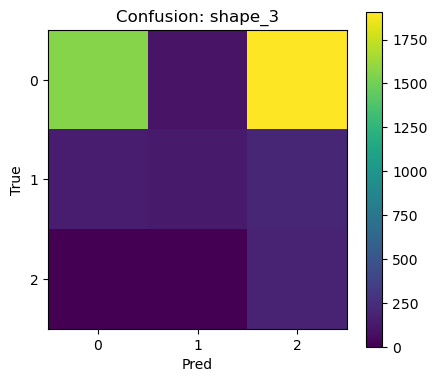

shape_4 labels: [0, 2, 3, 4]
                                   precision    recall  f1-score   support

                               no      0.988     0.506     0.669      3789
                       eyeglasses      0.090     0.310     0.140        58
                       sunglasses      0.000     0.000     0.000         3
have a glasses in hand or clothes      0.189     0.978     0.316       404

                         accuracy                          0.547      4254
                        macro avg      0.317     0.448     0.281      4254
                     weighted avg      0.899     0.547     0.628      4254



/Users/krishna/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 4, does not match size of target_names, 5
  warnings.warn(


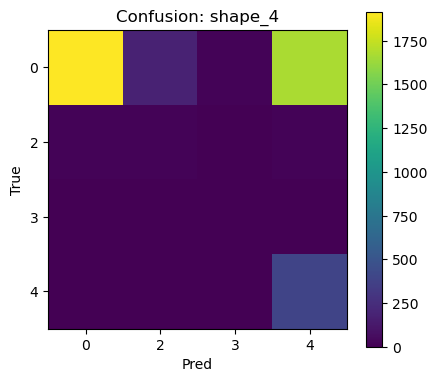

In [63]:
# Confusion matrix + report for a given head (e.g., 'shape_3' or 'shape_4')
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def head_confusion_from_df(df, head, labels=None, label_names=None):
    d = df.dropna(subset=[f"{head}_gt"]).copy()
    y_true = d[f"{head}_gt"].astype(int).values
    y_pred = d[f"{head}_pred"].astype(int).values
    if labels is None:
        labels = sorted(np.unique(y_true).tolist())
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    print(f"{head} labels: {labels}")
    print(classification_report(y_true, y_pred, labels=labels, target_names=(label_names or [str(i) for i in labels]), digits=3))

    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion: {head}")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.colorbar(); plt.xticks(range(len(labels)), labels); plt.yticks(range(len(labels)), labels)
    plt.tight_layout(); plt.show()

# Examples: hats & glasses
head_confusion_from_df(pred_df, 'shape_3', label_names=SHAPE_MAP['shape_3'])
head_confusion_from_df(pred_df, 'shape_4', label_names=SHAPE_MAP['shape_4'])

### Error Gallery for Misclassified Samples
This cell provides a visual error analysis tool that helps inspect where the model struggles by directly displaying misclassified images.

##### What the code does
Filters validation predictions (df) for a specific attribute head (e.g., shape_3 for Hat Presence). Selects only rows where the predicted label ≠ ground truth label. Displays the first n misclassified samples in a grid (n=12 by default, arranged into rows/columns).

##### For each image:
Opens it from the dataset folder. Displays the ground truth label (GT) and predicted label (Pred) side by side in the title. Uses human-readable labels (via ID2NAME) for better interpretation.

#### Why this is important
Visual inspection: You can see actual failure cases, not just numbers, which helps identify whether errors are due to: Ambiguous clothing items (e.g., a hat partly hidden). Poor image quality or lighting. Class overlap (e.g., eyeglasses vs. sunglasses).

##### Pattern discovery: 
By reviewing a batch of misclassifications, recurring mistakes (like bias toward “NA” classes or confusion between similar fabrics) become clearer.
Dataset improvement: Highlights where more training samples, balancing, or augmentation may be needed.
Model debugging: Confirms whether errors are due to data issues or model limitations.

##### Example Usage
show_errors(pretty, 'shape_3', n=12)
Shows 12 misclassified samples for Hat Presence.
show_errors(pretty, 'shape_4', n=12)
Displays eyewear-related misclassification cases (e.g., confusing glasses in hand vs. worn glasses).

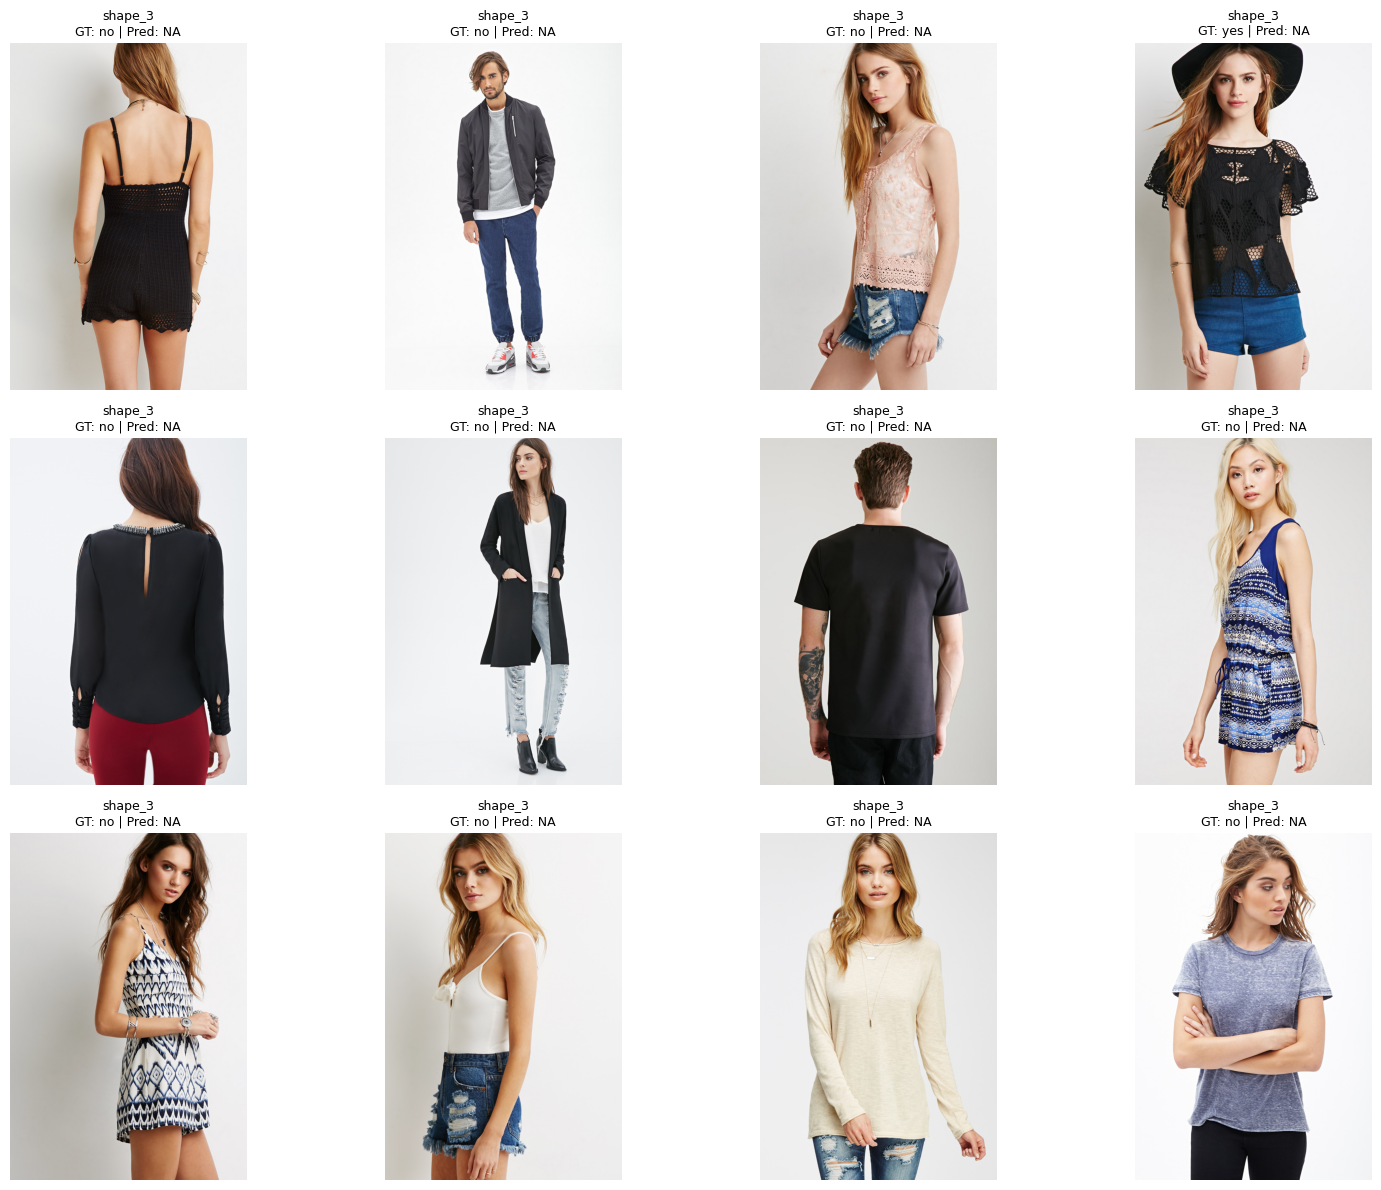

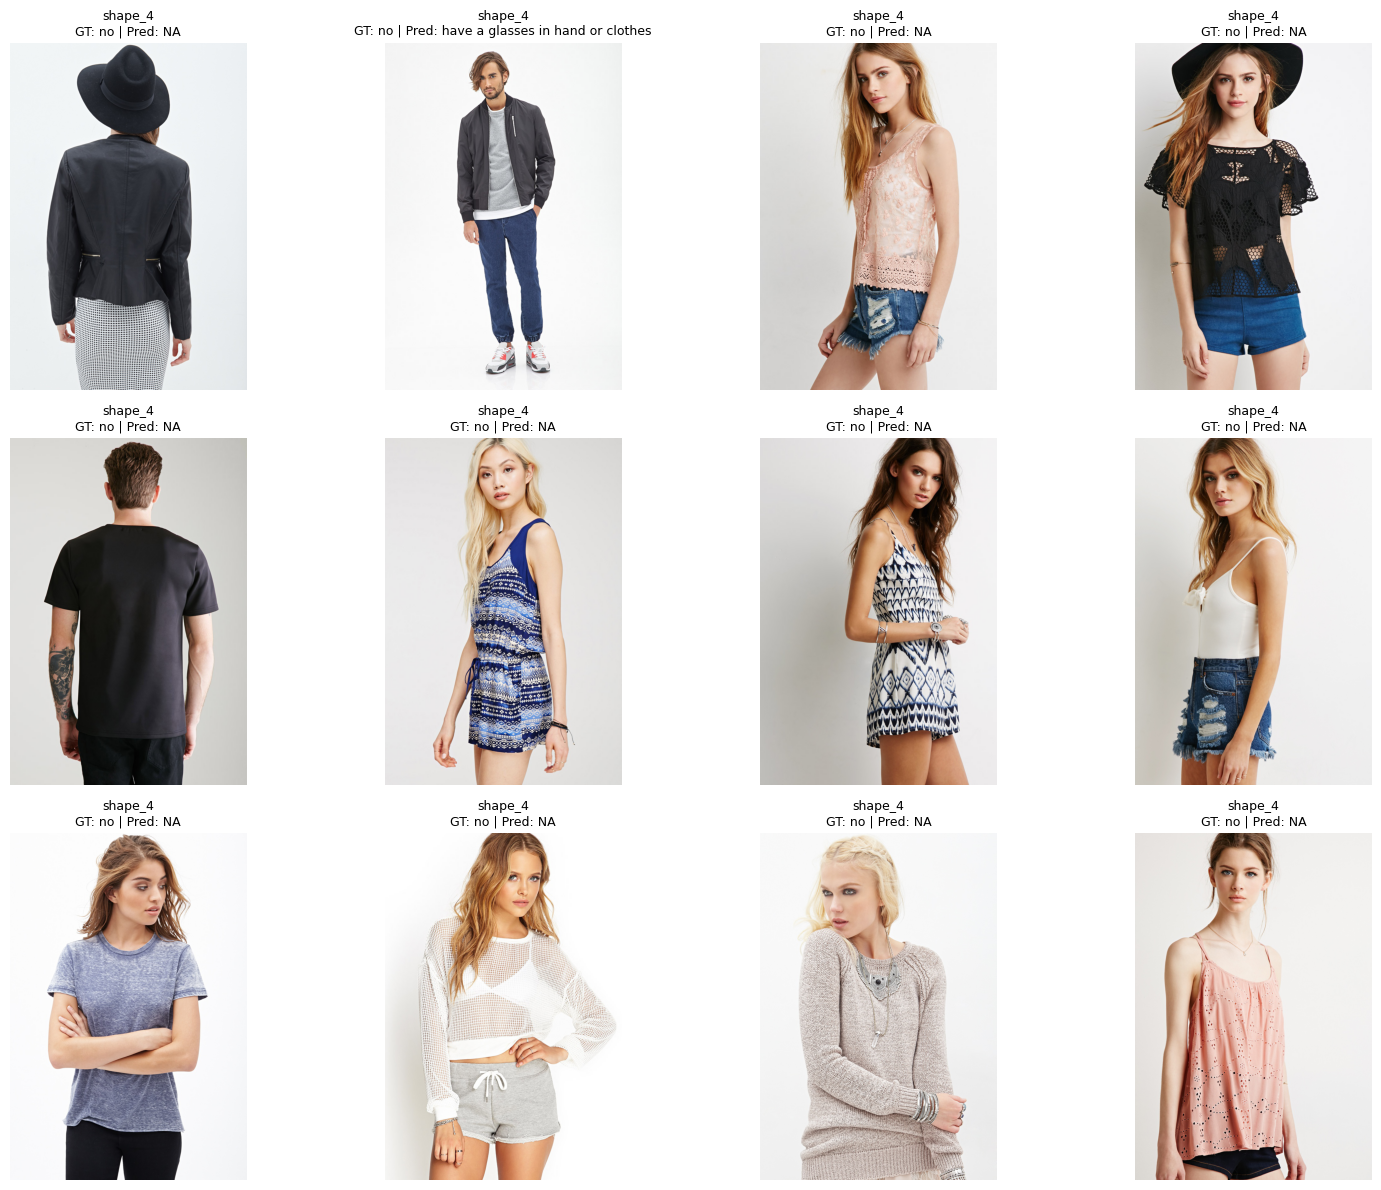

In [65]:
# Error gallery: show N misclassified images for a head
from PIL import Image

def show_errors(df, head, n=12, cols=4):
    d = df.dropna(subset=[f"{head}_gt"]).copy()
    d = d[d[f"{head}_pred"] != d[f"{head}_gt"]].head(n)
    rows = int(np.ceil(len(d)/cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i, (_, r) in enumerate(d.iterrows()):
        img = Image.open(os.path.join(IM_DIR, r['image'])).convert('RGB')
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img); ax.axis('off')
        gt = int(r[f"{head}_gt"]); pr = int(r[f"{head}_pred"])
        gt_name = ID2NAME[head][gt] if head in ID2NAME else gt
        pr_name = ID2NAME[head][pr] if head in ID2NAME else pr
        ax.set_title(f"{head}\nGT: {gt_name} | Pred: {pr_name}", fontsize=9)
    plt.tight_layout(); plt.show()

# Examples
show_errors(pretty, 'shape_3', n=12)
show_errors(pretty, 'shape_4', n=12)

### Phase 2 — Gradio Inference App: Multi-Attribute Fashion Predictor

This cell builds a lightweight **web UI** (with Gradio) to run trained multi-task model on **new, user-uploaded images** and display **human-readable** attribute predictions.

- **Transforms for inference:** Images are resized to 256 px, center-cropped to 224×224, converted to tensors, and normalized with ImageNet statistics—matching the model’s training setup for consistent predictions.
- **Predictor function (`predict_image`)**:  
  Runs the model in `eval()` under `no_grad()`, computes per-head logits, takes `argmax` for each head, and **decodes numeric class IDs** to text using `ID2NAME`. Display names are cleaned via `HEAD_DISPLAY` (e.g., “Sleeve Length”, “Upper Fabric”).
- **Interactive UI:**  
  A simple interface with an image uploader and a **“Predict Attributes”** button. The output is a JSON panel mapping each attribute (e.g., *Sleeve Length*, *Upper Fabric*, *Upper Color*) to its predicted label (e.g., *long-sleeve*, *denim*, *floral*).
- **Reproducibility & safety:**  
  Uses `@torch.no_grad()` to avoid gradient tracking and ensures deterministic, fast inference. The app launches locally so you can demo Phase 2 independently from the filtering tool.

In [67]:
# !pip install gradio -q
import gradio as gr
import torch
import torchvision.transforms as T
from PIL import Image
# --- Human-friendly display names for heads ---
HEAD_DISPLAY = {
    'shape_0': 'Sleeve Length',
    'shape_1': 'Pant Length',
    'shape_2': 'Legwear Type',
    'shape_3': 'Hat Presence',
    'shape_4': 'Eyewear Type',
    'shape_5': 'Neckwear Presence',
    'shape_6': 'Wrist Accessory',
    'shape_7': 'Ring Presence',
    'shape_8': 'Belt / Clothing Accessory',
    'shape_9': 'Neckline Type',
    'shape_10': 'Cardigan Presence',
    'shape_11': 'Covers Navel',
    'upper_fabric': 'Upper Fabric',
    'lower_fabric': 'Lower Fabric',
    'outer_fabric': 'Outer Fabric',
    'upper_color': 'Upper Color',
    'lower_color': 'Lower Color',
    'outer_color': 'Outer Color'
}
# Inference transform
infer_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224),
    T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# Predict with nice display names
@torch.no_grad()
def predict_image(img: Image.Image):
    model.eval()
    x = infer_tf(img.convert('RGB')).unsqueeze(0).to(device)
    out = model(x)  # dict of logits
    result = {}
    for h, logits in out.items():
        pred = logits.argmax(1).item()
        name_list = ID2NAME.get(h)
        if name_list:
            pred_label = name_list[pred]
        else:
            pred_label = int(pred)
        display_name = HEAD_DISPLAY.get(h, h)
        result[display_name] = pred_label
    return result

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Multi-Modal Fashion Attribute Detector")
    inp = gr.Image(type="pil", label="Upload an Image")
    btn = gr.Button("Predict Attributes")
    out = gr.JSON(label="Predicted Attributes (Human Readable)")
    btn.click(fn=predict_image, inputs=inp, outputs=out)

demo.launch(share=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
